# PART I: Prepare and clean the data

First, install OWSLib package that will enable getting ZIP code (in German: PLZ) geodata from Berlin Open Data, a data portal provided by the local govt in Berlin

In [3]:
#conda install -c conda-forge owslib

In [4]:
# import key libraries
import numpy as np
import pandas as pd
import requests
import geocoder
from owslib.wfs import WebFeatureService
# import beautiful soup library for scraping
from bs4 import BeautifulSoup

German postcodes with coordinates are available here: https://www.wiwald.com/ds/kostenlose-liste-deutscher-postleitzahlen-und-zugehoeriger-orte/id/ww-german-postal-codes. I have downloaded a json file and will convert it into a pandas dataframe.

In [66]:
df_plz=pd.read_json('ww-german-postal-codes.json', orient='index')
df_plz.head()

primary_key  zipcode         city        state  \
1            1     1945    Grünewald  Brandenburg   
2            2     1945     Lindenau  Brandenburg   
3            3     1945   Hohenbocka  Brandenburg   
4            4     1945  Schwarzbach  Brandenburg   
5            5     1945     Guteborn  Brandenburg   

                         community  latitude  longitude  
1  Landkreis Oberspreewald-Lausitz   51.4000    14.0000  
2  Landkreis Oberspreewald-Lausitz   51.4000    13.7333  
3  Landkreis Oberspreewald-Lausitz   51.4310    14.0098  
4  Landkreis Oberspreewald-Lausitz   51.4500    13.9333  
5  Landkreis Oberspreewald-Lausitz   51.4167    13.9333

Now, this is for whole Germany - we are only interested in Berlin, so we remove all the tip codes (PLZ in German) for other towns

In [265]:
df_plz=df_plz.loc[df_plz['state'] == 'Berlin']
# df_plz.head()
df_plz.head()

primary_key  zipcode    city   state      community  latitude  longitude
1288         1288    10115  Berlin  Berlin  Berlin, Stadt   52.5323    13.3846
1289         1289    10117  Berlin  Berlin  Berlin, Stadt   52.5170    13.3872
1290         1290    10119  Berlin  Berlin  Berlin, Stadt   52.5305    13.4053
1291         1291    10178  Berlin  Berlin  Berlin, Stadt   52.5213    13.4096
1292         1292    10179  Berlin  Berlin  Berlin, Stadt   52.5122    13.4164

Now we would like to add 2 things to this dataframe: 1- The population per PLZ, and 2- Neighborhood per PLZ. these are available from the local statistics agency in Berlin: https://www.statistik-berlin-brandenburg.de/publikationen/Stat_Berichte/2018/SB_A01-05-00_2017h02_BE.xlsx. I have made a csv from the relevant worksheet.

In [93]:
df_einw=pd.read_csv('PLZ_Kiez_Einwohner.csv', delimiter =';', sep=';')
df_einw.head()
#df_einw.shape

PLZ                  Kiez  Einwohner
0  10115                 Mitte      26274
1  10117                 Mitte      15531
2  10119                 Mitte      15064
3  10119                Pankow       4606
4  10178  Friedrichsh.-Kreuzb.         81

Now, as there are instances of more than one neighborhood (in German: Kiez) per PLZ, as for example PLZ 10119 above, we aggregate that information in the rows: Each row shows one PLZ with its population and the corresponding neighborhood(s)

In [96]:
df_einw_clean=df_einw.groupby(['PLZ']).agg({'Einwohner':'sum', 'Kiez':'sum'})
df_einw_clean.head(5)
#df_einw_clean.sum(axis=0)
#df_einw_clean.shape

Einwohner                       Kiez
PLZ                                        
10115      26274                      Mitte
10117      15531                      Mitte
10119      19670                MittePankow
10178      14466  Friedrichsh.-Kreuzb.Mitte
10179      23970  Friedrichsh.-Kreuzb.Mitte

Now that we have the population and the geodata, we would be interested in the purchasing power per neighborhood, ideally per PLZ code. There is a webpage of a German newspaper, Bild, showing that info as a table. Although the information is older (2013), the relative purchasing power across neighborhoods is quite stable so we should be able to use it for our purposes. Here's the link: https://www.bild.de/regional/berlin/einkommen/kaufkraft-liste-berliner-kieze-28373092.bild.html . We can scrape the tables using Beautiful Soup. 

In [114]:
page = requests.get('https://www.bild.de/regional/berlin/einkommen/kaufkraft-liste-berliner-kieze-28373092.bild.html')
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find_all('table')
df_income=pd.DataFrame()
for i in range(12):
    data=pd.read_html(str(table))[i]
    df_income=df_income.append(data)
#df_income = pd.read_html(str(table))[11]
df_income.head()

PLZ, Lage Kaufkraft pro Haushalt* Rang**
0       10585 Deutsche Oper​               3015 Euro     45
1  10587 TU/Otto-Suhr-Allee​               2753 Euro     81
2    10589 Mierendorffplatz​               2718 Euro     90
3        10623 Savignyplatz​               3545 Euro     15
4   10625 Karl-August-Platz​               3048 Euro     40

In [115]:
df_income

PLZ, Lage Kaufkraft pro Haushalt* Rang**
0        10585 Deutsche Oper​               3015 Euro     45
1   10587 TU/Otto-Suhr-Allee​               2753 Euro     81
2     10589 Mierendorffplatz​               2718 Euro     90
3         10623 Savignyplatz​               3545 Euro     15
4    10625 Karl-August-Platz​               3048 Euro     40
..                        ...                     ...    ...
10        12557 Wendenschloß​               2477 Euro    133
11          12559 Müggelheim​               2490 Euro    130
12     12587 Friedrichshagen​               2405 Euro    147
13          12589 Rahnsdorf ​               3164 Euro     30
14                     Bezirk               2378 Euro    NaN

[202 rows x 3 columns]

Doesn't look bad, but we have to clean it a little, as PLZ is shown with location information, each neighboprhood has its average value showing up as duplicates and the income figure is shown with string "Euro". Let's clean this up:

In [118]:
df_income.drop_duplicates(subset=['PLZ, Lage'], keep=False, inplace=True)
df_income.shape

(190, 3)

In [737]:
new = df_income['PLZ, Lage'].str.split(" ", n = 1, expand = True)
new2 = df_income['Kaufkraft pro Haushalt*'].str.split(n = 0, expand = True)
df_income['PLZ']=new[0]
df_income['income']=new2[0]
df_income.head()

PLZ, Lage Kaufkraft pro Haushalt* Rang**    PLZ Kaufkraft  \
0       10585 Deutsche Oper​               3015 Euro     45  10585      3015   
1  10587 TU/Otto-Suhr-Allee​               2753 Euro     81  10587      2753   
2    10589 Mierendorffplatz​               2718 Euro     90  10589      2718   
3        10623 Savignyplatz​               3545 Euro     15  10623      3545   
4   10625 Karl-August-Platz​               3048 Euro     40  10625      3048   

  income  
0   3015  
1   2753  
2   2718  
3   3545  
4   3048

Now 2 more things to get before we start our cluster analysis: 1- Political leanings per PLZ / neighborhood and 2- Number of coffee shops per neighborhood / PLZ. Plitical leanings. Results of the last election in Berlin are available under https://www.govdata.de/web/guest/daten/-/details/wahlen-in-berlin-2016-abgeordnetenhaus-und-bezirksverordnetenversammlungen-endgultiges-ergebnis . As the election regions are not identical with PLZ, I had to add a PLZ column into the data, using the mapping available here: https://www.wahlen-berlin.de/wahlen/BE2016/Wahlkreiseinteil/wahlkreiseinteil.asp. I saved the csv - let's see how it looks:

In [183]:
df_wahlen = pd.read_csv('Berlin_AH16_W1.csv', delimiter =';', sep=';')
df_wahlen.shape

(2432, 62)

Already looking good - but we have to clean up a bit: Postal votes cannot be mapped to PLZ so we have to get rid of them. Then we need to group the data by PLZ (the original df has more than 2000 rows, each row representing an election location.

In [188]:
df_wahlen.dropna(subset=['PLZ'], inplace=True)

In [189]:
df_wahlen.head()

Adresse    Stimmart  Bezirksnummer Bezirksname Wahlbezirk   Wahlbezirksart  \
37  01W100  Erststimme              1       Mitte        100  Urnenwahlbezirk   
38  01W101  Erststimme              1       Mitte        101  Urnenwahlbezirk   
39  01W102  Erststimme              1       Mitte        102  Urnenwahlbezirk   
40  01W103  Erststimme              1       Mitte        103  Urnenwahlbezirk   
41  01W104  Erststimme              1       Mitte        104  Urnenwahlbezirk   

        PLZ  Abgeordneten-\nhauswahlkreis  Bundestags-\nwahlkreis  \
37  10557.0                             1                      75   
38  10115.0                             1                      75   
39  10115.0                             1                      75   
40  10115.0                             1                      75   
41  10115.0                             1                      75   

   Berlin\nOstWest  ...  EB 9  EB 10  EB 11  EB 12  EB 13  EB 14  EB 15  \
37               W  ...     0      0      0      0      0      0      0   
38               O  ...     0      0      0      0      0      0      0   
39               O  ...     0      0      0      0      0      0      0   
40               O  ...     0      0      0      0      0      0      0   
41               O  ...     0      0      0      0      0      0      0   

    EB 16  EB 17  EB 18  
37      0      0      0  
38      0      0      0  
39      0      0      0  
40      0      0      0  
41      0      0      0  

[5 rows x 62 columns]

In [190]:
df_wahlen=df_wahlen.astype({'PLZ': int})
df_wahlen.head()

Adresse    Stimmart  Bezirksnummer Bezirksname Wahlbezirk   Wahlbezirksart  \
37  01W100  Erststimme              1       Mitte        100  Urnenwahlbezirk   
38  01W101  Erststimme              1       Mitte        101  Urnenwahlbezirk   
39  01W102  Erststimme              1       Mitte        102  Urnenwahlbezirk   
40  01W103  Erststimme              1       Mitte        103  Urnenwahlbezirk   
41  01W104  Erststimme              1       Mitte        104  Urnenwahlbezirk   

      PLZ  Abgeordneten-\nhauswahlkreis  Bundestags-\nwahlkreis  \
37  10557                             1                      75   
38  10115                             1                      75   
39  10115                             1                      75   
40  10115                             1                      75   
41  10115                             1                      75   

   Berlin\nOstWest  ...  EB 9  EB 10  EB 11  EB 12  EB 13  EB 14  EB 15  \
37               W  ...     0      0      0      0      0      0      0   
38               O  ...     0      0      0      0      0      0      0   
39               O  ...     0      0      0      0      0      0      0   
40               O  ...     0      0      0      0      0      0      0   
41               O  ...     0      0      0      0      0      0      0   

    EB 16  EB 17  EB 18  
37      0      0      0  
38      0      0      0  
39      0      0      0  
40      0      0      0  
41      0      0      0  

[5 rows x 62 columns]

In [194]:
df_wahlen.columns

Index(['Adresse', 'Stimmart', 'Bezirksnummer', 'Bezirksname', 'Wahlbezirk',
       'Wahlbezirksart', 'PLZ', 'Abgeordneten-\nhauswahlkreis',
       'Bundestags-\nwahlkreis', 'Berlin\nOstWest',
       'Wahlberechtigte insgesamt', 'Wahlberechtigte A1', 'Wahlberechtigte A2',
       'Wahlberechtigte A3', 'Wähler', 'Wähler B1', 'Ungültige Stimmen',
       'Gültige Stimmen', 'SPD', 'CDU', 'GRÜNE', 'DIE LINKE', 'PIRATEN', 'NPD',
       'FDP', 'Tierschutzpartei', 'pro Deutschland', 'Die PARTEI', 'BIG',
       'DKP', 'ödp', 'PSG', 'BüSo', 'B', 'DL', 'ALFA', 'Tierschutzallianz',
       'AfD', 'DIE EINHEIT', 'DIE VIOLETTEN', 'Graue Panther',
       'MENSCHLICHE WELT', 'MIETERPARTEI', 'Gesundheits-\nforschung', 'EB 1',
       'EB 2', 'EB 3', 'EB 4', 'EB 5', 'EB 6', 'EB 7', 'EB 8', 'EB 9', 'EB 10',
       'EB 11', 'EB 12', 'EB 13', 'EB 14', 'EB 15', 'EB 16', 'EB 17', 'EB 18'],
      dtype='object')

In [210]:
df_wahlen=df_wahlen[['Bezirksname', 'PLZ', 'Gültige Stimmen', 'SPD', 'CDU', 'GRÜNE', 'DIE LINKE',
                             'FDP', 'AfD']]

In [211]:
df_wahlen.head()

Bezirksname    PLZ  Gültige Stimmen  SPD  CDU  GRÜNE  DIE LINKE  FDP  AfD
37       Mitte  10557              461  129   83     88         75   13   59
38       Mitte  10115              707  169  143    178         83   57   58
39       Mitte  10115              566  130  112    131         65   58   60
40       Mitte  10115              635  140   92    192         92   61   38
41       Mitte  10115              600  148   99    167         66   66   37

So what we did here is we kept the columns with the main parties as well as total number of valid votes. SPD = social democrats, CDU= conservatives , Grüne = greens, linke = socialists, fdp= liberals, afd= far right. Let's group by PLZ to get what we need: Percentages per each party per PLZ.

In [212]:
df_wahlen_clean=df_wahlen.groupby(['PLZ']).agg({'Bezirksname':'max', 'Gültige Stimmen':'sum', 'SPD':'sum'
                                               ,'CDU':'sum', 'GRÜNE':'sum', 'DIE LINKE':'sum', 'FDP':'sum',
                                               'AfD':'sum'})
df_wahlen_clean['SPD']=df_wahlen_clean['SPD']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean['CDU']=df_wahlen_clean['CDU']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean['GRÜNE']=df_wahlen_clean['GRÜNE']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean['DIE LINKE']=df_wahlen_clean['DIE LINKE']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean['FDP']=df_wahlen_clean['FDP']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean['AfD']=df_wahlen_clean['AfD']/df_wahlen_clean['Gültige Stimmen']
df_wahlen_clean.head()

Bezirksname  Gültige Stimmen       SPD       CDU     GRÜNE  DIE LINKE  \
PLZ                                                                           
10115       Mitte             2958  0.244760  0.168357  0.262677   0.125085   
10117       Mitte             8971  0.230521  0.156170  0.177461   0.216475   
10119      Pankow             3563  0.213865  0.122930  0.336514   0.174011   
10178       Mitte             1544  0.253238  0.120466  0.102332   0.312824   
10179       Mitte             7142  0.259311  0.113974  0.145477   0.279194   

            FDP       AfD  
PLZ                        
10115  0.090264  0.078431  
10117  0.072902  0.113700  
10119  0.074937  0.044906  
10178  0.040803  0.139896  
10179  0.041025  0.125175

Now we're ready to get the final variable for our analysis: number of cafés per PLZ. For this, we're going to use the Foursquare API. 

In [235]:
import json

In [278]:
CLIENT_ID = 'XDP1E1K13BDFE051QJR1RGQSQITXQOFY2FC2KR4ECKTO5CGX'
CLIENT_SECRET = 'TOJPKLGKIKNDEOUEWMABC3OHCUPDTD5ACKLTRWI4C5SUPYYA' 
VERSION = '20180605' 
LIMIT = 100 # we want 100 results per PLZ
radius = 500 # we want to limit the radius from PLZ centre to 500m
categoryId = '4bf58dd8d48988d16d941735' # 4bf58dd8d48988d1e0931735' # IDs for café & coffee shop

In [280]:
def getNearbyVenues(names, latitudes, longitudes, radius=radius, categoryId=categoryId):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        venues_list.append(results)
    
    return(venues_list)

Now let's get the coffee shops per PLZ from foursquare:

In [281]:
berlin_cafes=getNearbyVenues(names=df_plz['zipcode'],
                                   latitudes=df_plz['latitude'],
                                   longitudes=df_plz['longitude']
                                  )
berlin_cafes

[{'meta': {'code': 200, 'requestId': '5fb16e69334c670565cb8409'},
  'response': {'headerLocation': 'Mitte',
   'headerFullLocation': 'Mitte, Berlin',
   'headerLocationGranularity': 'neighborhood',
   'query': 'cafe',
   'totalResults': 15,
   'suggestedBounds': {'ne': {'lat': 52.5368000045, 'lng': 13.39198368973932},
    'sw': {'lat': 52.5277999955, 'lng': 13.377216310260682}},
   'groups': [{'type': 'Recommended Places',
     'name': 'recommended',
     'items': [{'reasons': {'count': 0,
        'items': [{'summary': 'This spot is popular',
          'type': 'general',
          'reasonName': 'globalInteractionReason'}]},
       'venue': {'id': '4fd0f671e4b0044b25a40009',
        'name': 'Oslo Kaffebar',
        'location': {'address': 'Eichendorffstr. 13',
         'crossStreet': 'Invalidenstr.',
         'lat': 52.53102915837446,
         'lng': 13.386889100074768,
         'labeledLatLngs': [{'label': 'display',
           'lat': 52.53102915837446,
           'lng': 13.38688910007

In [283]:
#berlin_coffeshops=getNearbyVenues(names=df_plz['zipcode'],
#                                   latitudes=df_plz['latitude'],
#                                   longitudes=df_plz['longitude'],
#                                   categoryId='4bf58dd8d48988d1e0931735'
#                                  )
berlin_coffeshops

[{'meta': {'code': 200, 'requestId': '5fb16f41dfad1e14df23ba00'},
  'response': {'headerLocation': 'Mitte',
   'headerFullLocation': 'Mitte, Berlin',
   'headerLocationGranularity': 'neighborhood',
   'query': 'coffee shop',
   'totalResults': 11,
   'suggestedBounds': {'ne': {'lat': 52.5368000045, 'lng': 13.39198368973932},
    'sw': {'lat': 52.5277999955, 'lng': 13.377216310260682}},
   'groups': [{'type': 'Recommended Places',
     'name': 'recommended',
     'items': [{'reasons': {'count': 0,
        'items': [{'summary': 'This spot is popular',
          'type': 'general',
          'reasonName': 'globalInteractionReason'}]},
       'venue': {'id': '4fd0f671e4b0044b25a40009',
        'name': 'Oslo Kaffebar',
        'location': {'address': 'Eichendorffstr. 13',
         'crossStreet': 'Invalidenstr.',
         'lat': 52.53102915837446,
         'lng': 13.386889100074768,
         'labeledLatLngs': [{'label': 'display',
           'lat': 52.53102915837446,
           'lng': 13.3868

Now that we got the JSON files, let's put them into a pd dataframe:

In [485]:
berlin_cafes[0]['response']['groups'][0]['items'][2]['venue']['name']

'Brasserie La Bonne Franquette'

In [465]:
berlin_cafes[0]['response']['groups'][0]['items'][2]['venue']['location']['postalCode']

'10115'

In [492]:
cafes=[]
plz_cafes=[]
for i in range (195):
    for j in range (50):
        try:
            cafes.append(berlin_cafes[i]['response']['groups'][0]['items'][j]['venue']['name'])
        except:
            cafes.append('NaN')

for i in range (195):
    for j in range (50):
        try:
            plz_cafes.append(berlin_cafes[i]['response']['groups'][0]['items'][j]['venue']['location']['postalCode'])
        except:
            plz_cafes.append('NaN')            

cafe_dict={'PLZ':plz_cafes,'Venue':cafes}

In [494]:
df_cafe=pd.DataFrame.from_dict(cafe_dict)
df_cafe.head()

PLZ                          Venue
0  10115                  Oslo Kaffebar
1    NaN                     Café Bondi
2  10115  Brasserie La Bonne Franquette
3    NaN                 Espresso House
4  10115                        19grams

In [505]:
coffeeshops=[]
plz_coffeeshops=[]
for i in range (195):
    for j in range (50):
        try:
            coffeeshops.append(berlin_coffeshops[i]['response']['groups'][0]['items'][j]['venue']['name'])
        except:
            coffeeshops.append('NaN')

for i in range (195):
    for j in range (50):
        try:
            plz_coffeeshops.append(berlin_coffeshops[i]['response']['groups'][0]['items'][j]['venue']['location']['postalCode'])
        except:
            plz_coffeeshops.append('NaN')            

coffeeshop_dict={'PLZ':plz_coffeeshops,'Venue':coffeeshops}

In [508]:
df_coffeeshop=pd.DataFrame.from_dict(coffeeshop_dict)
df_coffeeshop.head()

PLZ          Venue
0  10115  Oslo Kaffebar
1  10115            R/D
2  10115        19grams
3  10115       The Barn
4    NaN     Café Bondi

In [530]:
df_cafes_berlin=pd.concat([df_cafe, df_coffeeshop])

In [535]:
df_cafes_berlin=df_cafes_berlin[df_cafes_berlin.PLZ!='NaN']

In [612]:
df_cafes_berlin=df_cafes_berlin.astype({'PLZ':int})

In [613]:
df_cafes_number=df_cafes_berlin.groupby(['PLZ']).agg({'Venue':'count'})
df_cafes_number.head()

Venue
PLZ         
10115     21
10117     69
10119     68
10178    103
10179     20

Now we have x key dataframes: 1- df_plz 2-df_income 3-df_wahlen_clean 4-df_cafes_number and 5 df_einw_clean for population. We now need to merge them based on PLZ.

In [841]:
df_plz_clean=df_plz[['zipcode', 'latitude', 'longitude']]
df_plz_clean=df_plz_clean.rename(columns={'zipcode':'PLZ'})
df_plz_clean=df_plz_clean.set_index('PLZ')
df_income_clean=df_income[['PLZ', 'income']]
df_income_clean=df_income_clean.astype({'PLZ':int})
df_income_clean=df_income_clean.set_index('PLZ')

In [842]:
df=df_plz_clean.join(df_income_clean) # joined geodata with income figures

In [843]:
df=df.join(df_einw_clean) # joined with population figures

In [844]:
df_wahlen_clean=df_wahlen_clean[['SPD', 'CDU', 'GRÜNE', 'DIE LINKE', 'FDP', 'AfD']]
df=df.join(df_wahlen_clean) # joined with resp. political party % votes

In [845]:
df=df.join(df_cafes_number) # join with number of cafes

In [846]:
df=df.rename(columns={'Einwohner':'population', 'Venue':'number_of_cafes'})

In [855]:
for i in range(len(df['income'])):
    if df.iloc[i,2]=='k.A.':
        df.iloc[i,2]= 2696

In [853]:
# we now need to clean up the income column & convert to float
import math
x=float('nan')
i=0
while i < (len(df['income'])):
    try: 
        if math.isnan(df.iloc[i,2]) == True:
            df.iloc[i,2]= 2696
        else:
            df.iloc[i,2]=df.iloc[i,2]
        i+=1
    except TypeError:
        i+=1
        continue

In [856]:
df=df.astype({'income': float})

In [849]:
df.dropna(subset=['population'], inplace=True)

Now let's replace NaN values in number of cafes with 0s (assuming if foursquare doesn't show them, they're not there!)

In [857]:
for i in range(len(df['number_of_cafes'])):
    try: 
        if math.isnan(df.iloc[i,11])==True:
            df.iloc[i,11]=0
    except TypeError:
        continue

In [858]:
# replace the NaN values in the party vote columns with party averages for the whole of Berlin:
SPD = 0.248
CDU = 0.198
GRÜNE = 0.158
LINKE = 0.154
AFD = 0.141
FDP = 0.056

for i in range(len(df['SPD'])):
    try: 
        if math.isnan(df.iloc[i,5])==True:
            df.iloc[i,5]=SPD
            df.iloc[i,6]=CDU
            df.iloc[i,7]=GRÜNE
            df.iloc[i,8]=LINKE
            df.iloc[i,9]=FDP
            df.iloc[i,10]=AFD
    except TypeError:
        continue

In [859]:
df.head(20)

latitude  longitude  income  population  \
PLZ                                              
10115   52.5323    13.3846  3118.0     26274.0   
10117   52.5170    13.3872  3673.0     15531.0   
10119   52.5305    13.4053  3018.0     19670.0   
10178   52.5213    13.4096  2717.0     14466.0   
10179   52.5122    13.4164  2583.0     23970.0   
10243   52.5123    13.4394  2428.0     30655.0   
10245   52.5007    13.4647  2439.0     33509.0   
10247   52.5161    13.4656  2463.0     39491.0   
10249   52.5238    13.4428  2436.0     28885.0   
10315   52.5132    13.5148  2151.0     33424.0   
10317   52.4979    13.4908  2342.0     23027.0   
10318   52.4835    13.5287  2690.0     27217.0   
10319   52.4992    13.5188  2104.0     24481.0   
10365   52.5206    13.4969  2278.0     27052.0   
10367   52.5246    13.4821  2192.0     21735.0   
10369   52.5295    13.4695  2286.0     20386.0   
10405   52.5352    13.4257  2773.0     32065.0   
10407   52.5336    13.4492  2555.0     25254.0   
10409   52.5443    13.4414  1942.0     23033.0   
10435   52.5378    13.4112  2941.0     17400.0   

                                  Kiez       SPD       CDU     GRÜNE  \
PLZ                                                                    
10115                            Mitte  0.244760  0.168357  0.262677   
10117                            Mitte  0.230521  0.156170  0.177461   
10119                      MittePankow  0.213865  0.122930  0.336514   
10178        Friedrichsh.-Kreuzb.Mitte  0.253238  0.120466  0.102332   
10179        Friedrichsh.-Kreuzb.Mitte  0.259311  0.113974  0.145477   
10243             Friedrichsh.-Kreuzb.  0.185139  0.080490  0.259760   
10245             Friedrichsh.-Kreuzb.  0.171369  0.077022  0.312147   
10247       Friedrichsh.-Kreuzb.Pankow  0.156329  0.065162  0.327305   
10249       Friedrichsh.-Kreuzb.Pankow  0.205592  0.092083  0.210302   
10315                      Lichtenberg  0.227868  0.111517  0.071133   
10317  Friedrichsh.-Kreuzb.Lichtenberg  0.222026  0.102065  0.189577   
10318                      Lichtenberg  0.269375  0.160280  0.101124   
10319                      Lichtenberg  0.248000  0.198000  0.158000   
10365                      Lichtenberg  0.213463  0.092585  0.106927   
10367                      Lichtenberg  0.225220  0.113551  0.136763   
10369                      Lichtenberg  0.234551  0.102902  0.112843   
10405                           Pankow  0.257936  0.110728  0.245075   
10407                           Pankow  0.180162  0.097166  0.281377   
10409                           Pankow  0.246957  0.085797  0.139130   
10435                      MittePankow  0.244661  0.105743  0.308314   

       DIE LINKE       FDP       AfD  number_of_cafes  
PLZ                                                    
10115   0.125085  0.090264  0.078431             21.0  
10117   0.216475  0.072902  0.113700             69.0  
10119   0.174011  0.074937  0.044906             68.0  
10178   0.312824  0.040803  0.139896            103.0  
10179   0.279194  0.041025  0.125175             20.0  
10243   0.245244  0.031075  0.087722              6.0  
10245   0.216711  0.035244  0.067221              6.0  
10247   0.221043  0.025407  0.058736             25.0  
10249   0.274578  0.037836  0.112293              6.0  
10315   0.309392  0.024862  0.204617              4.0  
10317   0.270600  0.034022  0.121731              3.0  
10318   0.258043  0.033228  0.145587              8.0  
10319   0.154000  0.056000  0.141000              0.0  
10365   0.321659  0.026829  0.185659              0.0  
10367   0.274153  0.039523  0.156211              1.0  
10369   0.260881  0.030091  0.196131              4.0  
10405   0.208185  0.046244  0.067992             39.0  
10407   0.232794  0.046559  0.087045              4.0  
10409   0.263768  0.024348  0.153043              5.0  
10435   0.205681  0.062409  0.000000             53.0

#### GREAT! Now we have a cleaned-up dataset. We can start analyzing the data!

# PART II: Run cluster analysis based on ZIP codes

We'll do K-means clustering here. To find the optimal number of clusters, we'll utilize the "elbow method". Before we do that, the relevant colums are income, population, party votes and number of cafes per PLZ. Let's select & standardize these.

In [860]:
from sklearn.preprocessing import StandardScaler
X = df[['income','population','SPD','CDU','GRÜNE','DIE LINKE','FDP','AfD','number_of_cafes']].values
scaler = StandardScaler().fit(X)
# Standardize the columns.
df_stan = df.copy()
X_stan = scaler.transform(X)
df_stan[['income','population','SPD','CDU','GRÜNE','DIE LINKE',
         'FDP','AfD','number_of_cafes']] = X_stan
df_stan.head()

latitude  longitude    income  population                       Kiez  \
PLZ                                                                           
10115   52.5323    13.3846  0.795168    0.952178                      Mitte   
10117   52.5170    13.3872  2.028190   -0.566072                      Mitte   
10119   52.5305    13.4053  0.573001    0.018871                MittePankow   
10178   52.5213    13.4096 -0.095719   -0.716582  Friedrichsh.-Kreuzb.Mitte   
10179   52.5122    13.4164 -0.393421    0.626566  Friedrichsh.-Kreuzb.Mitte   

            SPD       CDU     GRÜNE  DIE LINKE       FDP       AfD  \
PLZ                                                                  
10115 -0.210863 -0.235586  1.075738  -0.303655  1.138978 -0.982463   
10117 -0.543981 -0.388277  0.120688   0.889122  0.565641 -0.430709   
10119 -0.933630 -0.804735  1.903248   0.334899  0.632851 -1.506950   
10178 -0.012519 -0.835603 -0.721307   2.146605 -0.494324 -0.020876   
10179  0.129548 -0.916949 -0.237758   1.707682 -0.486999 -0.251184   

       number_of_cafes  
PLZ                     
10115         0.833516  
10117         3.957918  
10119         3.892826  
10178         6.171036  
10179         0.768425

Now we can find out the ideal cluster number via elbow:

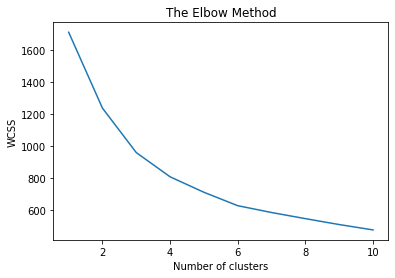

In [864]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_stan)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


#### So, K=4 seems to be a reasonable number for clusters, let's see what our analysis tells us:

In [972]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state =  42)
y_kmeans = kmeans.fit_predict(X_stan)

In [973]:
y_kmeans

array([1, 5, 5, 5, 4, 4, 4, 4, 4, 2, 4, 2, 4, 2, 4, 2, 4, 4, 4, 5, 5, 4,
       4, 1, 1, 1, 4, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 5, 1, 1, 5, 4, 5, 5, 4, 4, 5, 4, 4, 4, 4,
       3, 4, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 3, 1, 3,
       3, 0, 0, 3, 3, 1, 3, 4, 3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 4, 4, 4, 1, 1, 4, 1, 4, 4, 3, 3, 3, 3, 1, 3, 3,
       0, 0, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int32)

In [974]:
df['cluster'] = pd.Series(y_kmeans, index=df.index)

In [975]:
df.head()

latitude  longitude  income  population                       Kiez  \
PLZ                                                                         
10115   52.5323    13.3846  3118.0     26274.0                      Mitte   
10117   52.5170    13.3872  3673.0     15531.0                      Mitte   
10119   52.5305    13.4053  3018.0     19670.0                MittePankow   
10178   52.5213    13.4096  2717.0     14466.0  Friedrichsh.-Kreuzb.Mitte   
10179   52.5122    13.4164  2583.0     23970.0  Friedrichsh.-Kreuzb.Mitte   

            SPD       CDU     GRÜNE  DIE LINKE       FDP       AfD  \
PLZ                                                                  
10115  0.244760  0.168357  0.262677   0.125085  0.090264  0.078431   
10117  0.230521  0.156170  0.177461   0.216475  0.072902  0.113700   
10119  0.213865  0.122930  0.336514   0.174011  0.074937  0.044906   
10178  0.253238  0.120466  0.102332   0.312824  0.040803  0.139896   
10179  0.259311  0.113974  0.145477   0.279194  0.041025  0.125175   

       number_of_cafes  cluster    PLZ  
PLZ                                     
10115             21.0        1  10115  
10117             69.0        5  10117  
10119             68.0        5  10119  
10178            103.0        5  10178  
10179             20.0        4  10179

##### Let's investigate the clusters:

In [976]:
df.groupby(['cluster']).mean()

latitude  longitude       income    population       SPD       CDU  \
cluster                                                                        
0        52.484915  13.284307  3543.296296  14144.000000  0.250494  0.282043   
1        52.497458  13.344867  2763.250000  16075.187500  0.275193  0.175457   
2        52.513995  13.532224  2564.736842  21381.421053  0.222846  0.164129   
3        52.507223  13.318334  2623.857143  20346.542857  0.295699  0.259662   
4        52.515734  13.432853  2451.250000  25743.406250  0.230387  0.103602   
5        52.512290  13.413050  2837.600000  21002.100000  0.205435  0.088303   

            GRÜNE  DIE LINKE       FDP       AfD  number_of_cafes  \
cluster                                                             
0        0.164814   0.066754  0.105535  0.111677         6.962963   
1        0.225062   0.120458  0.062646  0.101202         7.354167   
2        0.072669   0.234640  0.023014  0.231119         1.263158   
3        0.090003   0.072123  0.066926  0.181405         0.742857   
4        0.225818   0.219064  0.034831  0.104523        10.437500   
5        0.328085   0.215162  0.040880  0.048443        60.800000   

                  PLZ  
cluster                
0        12753.370370  
1        11824.541667  
2        12515.368421  
3        13017.342857  
4        11581.406250  
5        10725.700000

The cluster analysis reveals some interesting insights:
Cluster 0: High-income / conseravtive neighborhood with low population: The PLZ areas in this cluster are parts of town with detached houses with high-income households who tend to elect conservative / center-right. Could potentially work for a high-end cafe if the design & interior is a bit more on the traditional side. 
Cluster 1: Average-income "green" residential areas: Similar to cluster 0 in terms of population and coffe shop density, while the political opinion is a bit more tilted toward the green party and the income is in-line with city average. Probably equally attractive as cluster 0, but the clientele will be completely different - need more vegan stuff!!
Cluster 2: Far-right / low income neighborhoods: Parts of town with low household income, tendency to elect far-right, very low number of coffe shops. Also high % for far-left. Former East-Berlin neighborhoods. Not interesting.
Cluster 3: Mixed neighborhoods: These neighborhoods are quite heterogeneous in that there is a large social democratic crowd but also a high number of far-right people. Number of cafes quite low, so also not really interesting for our coffe shop idea.
Cluster 4: "Poor, but sexy": Alternative cluster: This is interesting. Lower purchasing power, highly cosmopolitan, progressive and high-population. Probably student neighborhoods. Definitely interesting.
Cluster 5: Affluent porgressive green neighbohoods: This is the ideal cluster for our idea. Former leftie / green students who now are affluent and love to spend time and money in alternative but expensive coffe shops!

# PART III: Visualize results

Let's create a folium choropleth map with the PLZ / zip codes and their respective clusters:

In [984]:
df2=df
df2['PLZ']=df2.index
df2=df2.astype({'PLZ':str})
m = folium.Map(location=[52.52, 13.4], zoom_start=11)
folium.Choropleth(
    geo_data=plz_geo,
    data=df2,
    columns=['PLZ','cluster'],
    key_on='properties.plz',
    fill_color='Spectral',
    fill_opacity=0.7,
    line_opacity=0.5,
    reset=True
).add_to(m)

m

#### Awesome: Cluster 5 was the most interesting for us. Seems like the ideal spots for our coffee shop are in central part of former East-Berlin where affluent alternatives dominate, as well as in Kreuzberg. The green areas would be a second choice - so called "poor but sexy" alternative neighborhoods. We now have favorite locations for our new café!

Here's a bonus analysis: Income by zip code. Seems like richer parts of town elect conservative!

In [986]:
df2=df
df2['PLZ']=df2.index
df2=df2.astype({'PLZ':str})
m = folium.Map(location=[52.52, 13.4], zoom_start=11)
folium.Choropleth(
    geo_data=plz_geo,
    data=df2,
    columns=['PLZ','income'],
    key_on='properties.plz',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    reset=True
).add_to(m)

m